# Visualization

> Visualization utilities for RBE - particles, beliefs, comparisons, and summaries

In [ ]:
#| default_exp rbe.viz

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List, Dict, Tuple, Union
from fastcore.all import *
from technical_blog.rbe.probability import eff_size

## Style Configuration

In [ ]:
#| export
def set_style():
    "Set consistent plotting style for RBE visualizations"
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['grid.alpha'] = 0.3
    
# Apply style
set_style()

## Particle Visualization

In [ ]:
#| export
def particles(particles, 
              weights, 
              title='Particle Distribution',             
              figsize=(8, 6), alpha=0.6, ax=None):
    "Visualize `particles` with `weights`"    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure
    if particles.shape[1] == 1:
        # 1D case: weighted histogram
        ax.hist(particles.flatten(), weights=weights, bins=30, alpha=alpha, density=True)
        ax.set_xlabel('State')
        ax.set_ylabel('Probability Density')
    elif particles.shape[1] == 2:
        # 2D case: scatter plot
        scatter = ax.scatter(particles[:, 0], particles[:, 1], s=weights*1000, alpha=alpha)
        ax.set_xlabel('State 1')
        ax.set_ylabel('State 2')
    ax.set_title(title)
    return fig, ax

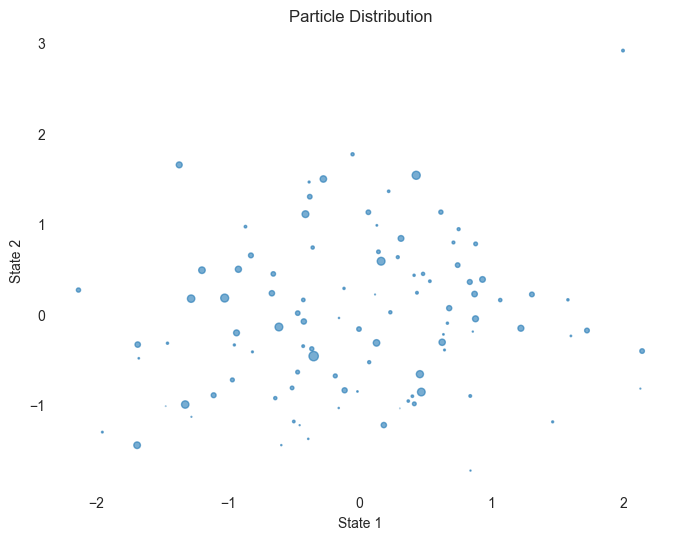

In [ ]:
# Test particle visualization
rng = np.random.default_rng(42)
test_particles = rng.normal(0, 1, (100, 2))
test_weights = rng.exponential(1, 100)
test_weights = test_weights / np.sum(test_weights)

ax = particles(test_particles, test_weights)
plt.show()

## Belief Evolution

In [ ]:
#| export
def beliefs(beliefs, time_steps=None, title='Belief Evolution', 
           figsize=(10, 6), labels=None, ax=None):
    "Visualize evolution of `beliefs` over `time_steps`"
    beliefs = np.array(beliefs)
    if time_steps is None:
        time_steps = np.arange(len(beliefs))
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure
    
    if beliefs.ndim == 2:
        # Multiple belief dimensions
        for i in range(beliefs.shape[1]):
            label = f'Belief {i+1}' if labels is None else labels[i]
            ax.plot(time_steps, beliefs[:, i], label=label, marker='o', linewidth=2)
        ax.legend()
    else:
        # Single belief dimension
        ax.plot(time_steps, beliefs, marker='o', linewidth=2)
    
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Belief Value')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    return fig, ax

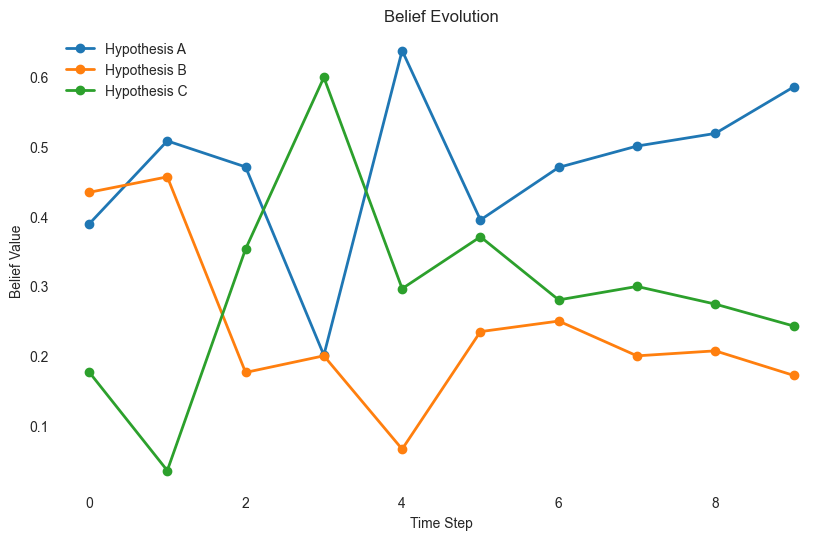

In [ ]:
# Test belief visualization
test_beliefs = np.random.random((10, 3))
test_beliefs = test_beliefs / test_beliefs.sum(axis=1, keepdims=True)  # Normalize

ax = beliefs(test_beliefs, labels=['Hypothesis A', 'Hypothesis B', 'Hypothesis C'])
plt.show()

## Method Comparison

In [ ]:
#| export
def comparison(methods_data, time_steps=None, title='Method Comparison',
              figsize=(12, 8), metrics=['mse', 'mae']):
    "Compare multiple methods with `methods_data` dict"
    if time_steps is None:
        # Infer time_steps from data
        first_method = list(methods_data.keys())[0]
        first_data = methods_data[first_method]
        
        if 'estimates' in first_data:
            time_steps = np.arange(len(first_data['estimates']))
        else:
            # Use first available metric
            available_metrics = [m for m in metrics if m in first_data]
            if available_metrics:
                time_steps = np.arange(len(first_data[available_metrics[0]]))
            else:
                time_steps = np.arange(10)  # Default
    
    n_metrics = len(metrics)
    fig, axes = plt.subplots(n_metrics, 1, figsize=figsize, squeeze=False)
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        for method_name, method_data in methods_data.items():
            if metric in method_data:
                ax.plot(time_steps[:len(method_data[metric])], method_data[metric], 
                       label=method_name, marker='o', linewidth=2)
        
        ax.set_xlabel('Time Step')
        ax.set_ylabel(metric.upper())
        ax.set_title(f'{title} - {metric.upper()}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, axes

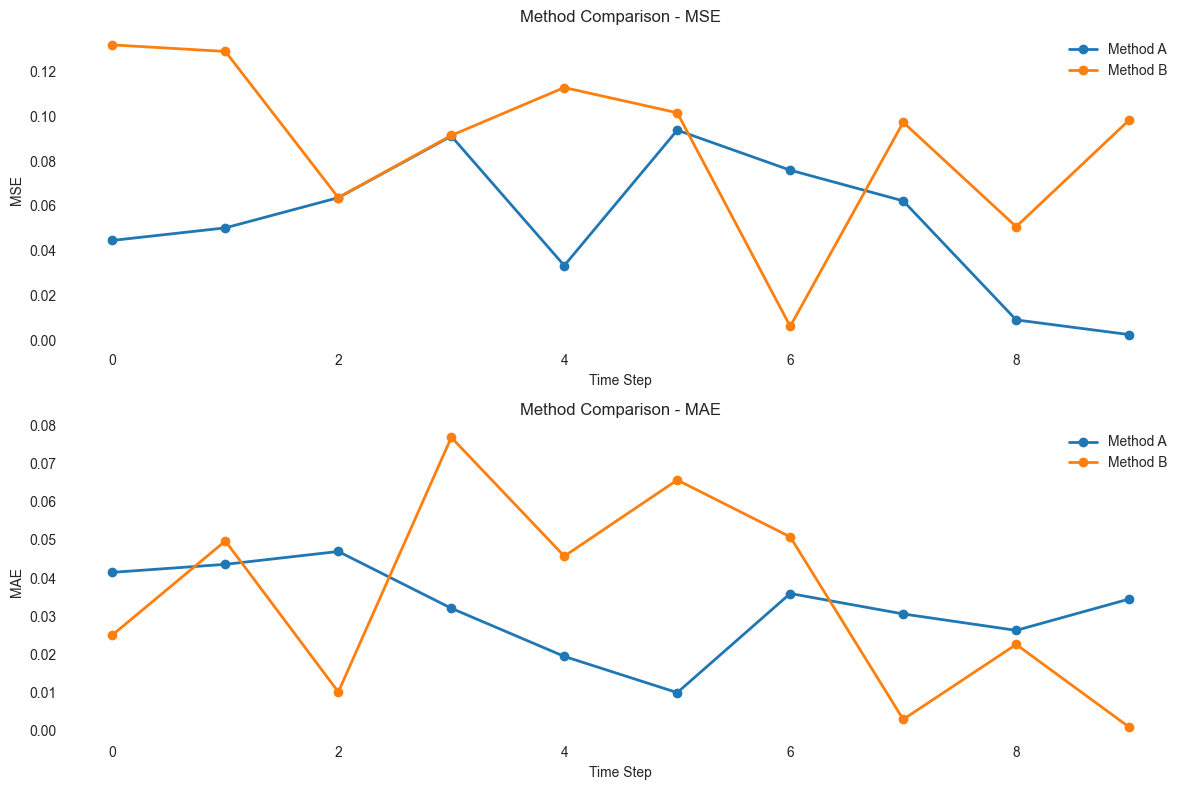

In [ ]:
# Test comparison visualization
test_methods = {
    'Method A': {'mse': np.random.random(10) * 0.1, 'mae': np.random.random(10) * 0.05},
    'Method B': {'mse': np.random.random(10) * 0.15, 'mae': np.random.random(10) * 0.08}
}

fig, axes = comparison(test_methods)
plt.show()

## RBE Summary Dashboard

In [ ]:
#| export
def summary(rbe_result, true_states=None, title='RBE Summary', figsize=(15, 10)):
    "Create comprehensive summary visualization of RBE results"
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # 1. Final particle distribution (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    if 'particles' in rbe_result and 'weights' in rbe_result:
        final_particles = rbe_result['particles'][-1]
        final_weights = rbe_result['weights'][-1]
        particles(final_particles, final_weights, 'Final Particle Distribution', ax=ax1)
    
    # 2. Estimates over time (top right)
    ax2 = fig.add_subplot(gs[0, 1])
    estimates = rbe_result['estimates']
    time_steps = np.arange(len(estimates))
    
    if estimates.ndim == 2 and estimates.shape[1] >= 2:
        ax2.plot(time_steps, estimates[:, 0], 'b-', label='Dim 1', marker='o')
        ax2.plot(time_steps, estimates[:, 1], 'r-', label='Dim 2', marker='s')
        if true_states is not None:
            true_states = np.array(true_states)
            ax2.plot(time_steps, true_states[:, 0], 'b--', alpha=0.7, label='True Dim 1')
            ax2.plot(time_steps, true_states[:, 1], 'r--', alpha=0.7, label='True Dim 2')
    else:
        ax2.plot(time_steps, estimates.flatten(), 'b-', marker='o', label='Estimate')
        if true_states is not None:
            ax2.plot(time_steps, np.array(true_states).flatten(), 'r--', alpha=0.7, label='True')
    
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('State Value')
    ax2.set_title('Estimates Over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Effective sample size (bottom left)
    ax3 = fig.add_subplot(gs[1, 0])
    if 'eff_sizes' in rbe_result:
        eff_sizes = rbe_result['eff_sizes']
    elif 'weights' in rbe_result:
        eff_sizes = [eff_size(w) for w in rbe_result['weights']]
    else:
        eff_sizes = None
    
    if eff_sizes is not None:
        ax3.plot(np.arange(len(eff_sizes)), eff_sizes, 'g-', marker='o')
        if 'particles' in rbe_result:
            n_particles = len(rbe_result['particles'][0])
            ax3.axhline(n_particles/2, color='r', linestyle='--', alpha=0.7, label='N/2')
        ax3.set_xlabel('Time Step')
        ax3.set_ylabel('Effective Sample Size')
        ax3.set_title('Particle Filter Health')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # 4. Error metrics (bottom right)
    ax4 = fig.add_subplot(gs[1, 1])
    if true_states is not None:
        errors = np.array(true_states) - estimates
        if errors.ndim == 2:
            error_norms = np.linalg.norm(errors, axis=1)
        else:
            error_norms = np.abs(errors)
        
        ax4.plot(time_steps, error_norms, 'r-', marker='o')
        ax4.set_xlabel('Time Step')
        ax4.set_ylabel('Estimation Error')
        ax4.set_title('Error Over Time')
        
        # Add summary statistics
        rmse = np.sqrt(np.mean(error_norms**2))
        mae = np.mean(error_norms)
        ax4.text(0.02, 0.98, f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
                transform=ax4.transAxes, va='top',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    else:
        ax4.text(0.5, 0.5, 'No true states\nprovided', ha='center', va='center', 
                transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Error Analysis')
    ax4.grid(True, alpha=0.3)
    
    fig.suptitle(title, fontsize=16)
    return fig

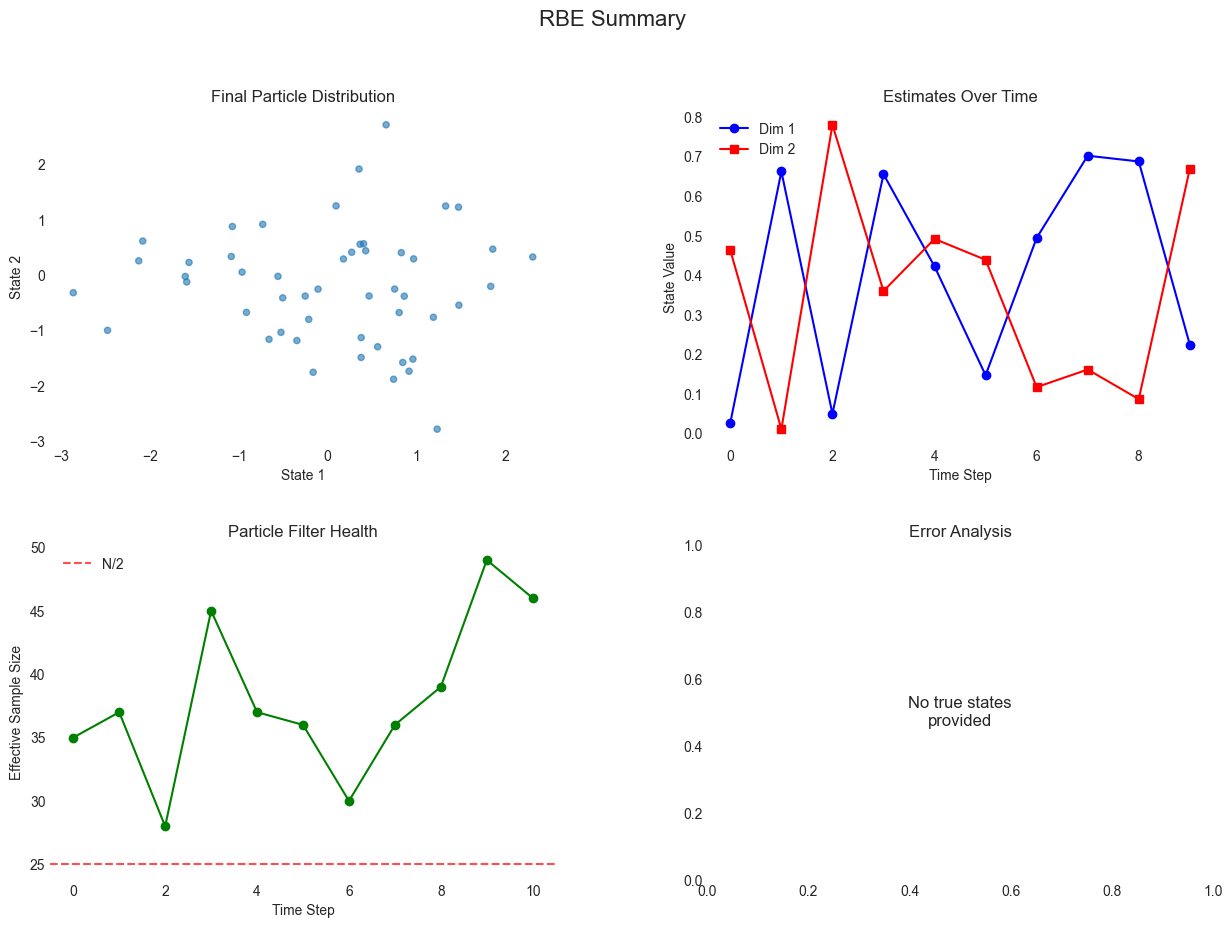

In [ ]:
# Test summary visualization with mock data
test_result = {
    'estimates': np.random.random((10, 2)),
    'particles': [rng.normal(0, 1, (50, 2)) for _ in range(11)],
    'weights': [np.ones(50)/50 for _ in range(11)],
    'eff_sizes': np.random.randint(20, 50, 11)
}

fig = summary(test_result)
plt.show()

## Animated Particle Evolution

In [ ]:
#| export
def animate_particles(particle_history, weight_history, 
                     observations=None, estimates=None,
                     interval=200, figsize=(10, 8)):
    "Create animation of particle evolution (returns animation instructions)"
    # Note: In FastHTML, this would return instructions for JavaScript animation
    # Here we return the setup for potential matplotlib animation
    
    n_steps = len(particle_history)
    
    return {
        'n_frames': n_steps,
        'interval': interval,
        'particle_history': particle_history,
        'weight_history': weight_history,
        'observations': observations,
        'estimates': estimates,
        'figsize': figsize
    }

## Uncertainty Visualization

In [ ]:
#| export
def uncertainty_bands(estimates, particles, weights, 
                     confidence_levels=[0.5, 0.9], 
                     title='Estimates with Uncertainty',
                     figsize=(10, 6)):
    "Plot estimates with uncertainty bands from particle distribution"
    fig, ax = plt.subplots(figsize=figsize)
    
    time_steps = np.arange(len(estimates))
    estimates = np.array(estimates)
    
    # Plot estimates
    if estimates.ndim == 1:
        ax.plot(time_steps, estimates, 'b-', linewidth=2, label='Estimate')
        
        # Calculate uncertainty bands
        for level, alpha in zip(confidence_levels, [0.3, 0.15]):
            lower = []
            upper = []
            
            for t, (p, w) in enumerate(zip(particles[1:], weights[1:])):
                # Weighted quantiles
                sorted_idx = np.argsort(p.flatten())
                sorted_p = p.flatten()[sorted_idx]
                sorted_w = w[sorted_idx]
                cum_w = np.cumsum(sorted_w)
                
                lower_q = (1 - level) / 2
                upper_q = 1 - lower_q
                
                lower_idx = np.searchsorted(cum_w, lower_q)
                upper_idx = np.searchsorted(cum_w, upper_q)
                
                lower.append(sorted_p[lower_idx])
                upper.append(sorted_p[upper_idx])
            
            ax.fill_between(time_steps, lower, upper, alpha=alpha, 
                          label=f'{level*100:.0f}% CI')
    
    ax.set_xlabel('Time Step')
    ax.set_ylabel('State Value')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return fig, ax

## Export

In [ ]:
#| export
__all__ = [
    # Style
    'set_style',
    
    # Core visualizations
    'particles', 'beliefs', 'comparison', 'summary',
    
    # Advanced visualizations
    'animate_particles', 'uncertainty_bands'
]